# IMPORT LIBRARY YANG DIPERLUKAN

Pada tahap ini import library yang penting. untuk keperluan development model.

In [1]:
import wandb
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import dill
import re

from wandb.integration.keras import WandbMetricsLogger
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

# SETUP CONSTANTS

Dalam blok ini, kita mendefinisikan berbagai konstanta yang digunakan dalam proses pelatihan dan evaluasi model. Konstanta-konstanta ini meliputi path (lokasi direktori) untuk dataset, objek model, laporan pelatihan, serta hyperparameter penting seperti ukuran batch, jumlah epoch, ukuran gambar, dan parameter optimasi.

## function

In [2]:
def load_object(file_path):
    """
    Fungsi untuk memuat objek dari file dengan menggunakan modul `dill`.

    Args:
        file_path (str): Lokasi file dari objek yang ingin dimuat.

    Returns:
        object: Objek yang dimuat dari file.
    """

    try:
        with open(file_path, 'rb') as file_obj:
            return dill.load(file_obj)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

## main program

In [3]:
# ==========================================================================================
# ==================================== PARENT PATH CONSTANT ================================
# ==========================================================================================
PARENT_DATASET_PATH = ".."
PARENT_DATASET_PATH = ".."
ARTIFACTS_PATH = os.path.join(PARENT_DATASET_PATH, "artifacts")
DATA_INGESTION_ARTIFACTS_DIR_PATH = os.path.join(ARTIFACTS_PATH, "data_ingestion")
DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH = os.path.join(ARTIFACTS_PATH, "data_transformation")
OBJECT_PATH = os.path.join(ARTIFACTS_PATH, "objects")
REPORT_PATH = os.path.join(ARTIFACTS_PATH, "reports")



# ==========================================================================================
# ==================================== DATA PATH CONSTANT ==================================
# ==========================================================================================
TRAIN_PATH = os.path.join(DATA_INGESTION_ARTIFACTS_DIR_PATH, "dataset-resized")
TRAIN_TFRECOARD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "train_trashnet.tfrecord")
VALID_TFRECORD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "valid_trashnet.tfrecord")



# ==========================================================================================
# ==================================== REPORTS PATH CONSTANT ===============================
# ==========================================================================================
MODEL_NAME = "DenseNet121"
TARGET_KERAS_MODEL_PATH = os.path.join(OBJECT_PATH, f"{MODEL_NAME}_model.keras")
TABEL_TRAINING_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "tabel_pelatihan.csv")
TABEL_EPOCH_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "tabel_epoch.csv")
PLOT_TRAINING_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "plot_pelatihan.png")
PLOT_CONFUSION_MATRIX_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "plot_confusion_matrix.png")
CLASSIFICATION_REPORT_PATH = os.path.join(REPORT_PATH, MODEL_NAME, "classification_report.txt")



# ==========================================================================================
# =============================== OBJECT PATH CONSTANT  ====================================
# ==========================================================================================
LABEL_LIST_PATH = os.path.join(OBJECT_PATH, "label_list.pkl")
CLASS_WEIGHTS_PATH = os.path.join(OBJECT_PATH, "class_weights.pkl")
LABEL_LIST = load_object(LABEL_LIST_PATH)
CLASS_WEIGHTS = load_object(CLASS_WEIGHTS_PATH)
IMAGE_SIZE = (224, 224)

# TRAINING WORKFLOW

## Step 1. Build Architecture Model


### function

In [6]:
base_model = tf.keras.applications.DenseNet121 (
    weights='imagenet',
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3) 
)
base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

Pada langkah ini, kita akan membangun arsitektur model deep learning menggunakan **VGG16** sebagai base model (pretrained). Base model ini dilatih sebelumnya di dataset ImageNet dan akan digunakan sebagai extractor fitur untuk dataset kita.

- **Base Model (DenseNet121)**: Arsitektur model ini digunakan sebagai dasar karena telah dilatih di dataset besar (ImageNet), sehingga dapat mengenali pola fitur visual umum dalam gambar. Kita tidak menggunakan lapisan output dari pretrained model ini (`include_top=False`) agar dapat menyesuaikan dengan dataset kita sendiri.
- **Global Average Pooling**: Setelah melewati base model, kita menambahkan lapisan pooling untuk mereduksi dimensi output dari base model. Pooling ini mengambil rata-rata dari semua fitur untuk menghasilkan satu vektor per channel, sehingga dapat lebih mudah diproses di lapisan fully connected berikutnya.
- **Output Layer**: Terakhir, kita menambahkan lapisan output dengan aktivasi sigmoid. Jika klasifikasi binari, lapisan ini menghasilkan 1 output node, sedangkan jika klasifikasi multi-kelas, lapisan ini menghasilkan output sebanyak jumlah kelas.
- **Trainability**: Bagian pretrained model bisa dipilih apakah akan ikut dilatih atau tidak dengan mengatur `base_model_trainable`.

Fungsi `build_model` digunakan untuk membangun dan meng-compile model dengan loss, metrics, optimizer yang didefinisikan.

In [ ]:
def build_model(
      input_shape=None,
      num_classes=None,
      pretrained_model=None,
    ):
    # Input layer
    input_layer = tf.keras.Input(shape=input_shape)

    # Base model pretrained
    pretrained_model.trainable = False

    # Input melewati base model
    x = pretrained_model(input_layer, training=False)

    # Global average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    output_num = 1 if len(num_classes) == 2 else len(num_classes)
    activation = 'sigmoid' if output_num == 1 else 'softmax'
    output_layer = tf.keras.layers.Dense(output_num, activation=activation)(x)

    # Membuat model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

Give `wandb.init` your config

In [17]:
run = wandb.init(
    project='trashnet-adatama-test',
    config={
        "learning_rate": 0.001,
        "loss_function": "sparse_categorical_crossentropy",
        "metrics": ['accuracy'],
        "batch_size": 32,
        "epochs": 150,
        "architecture": "DenseNet121",
        "dataset": "TrashNet",
    }
)

config = wandb.config


model = build_model(
    input_shape=(*IMAGE_SIZE, 3),
    num_classes=LABEL_LIST,
    pretrained_model=base_model,
  )


optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

model.compile(
    optimizer=optimizer,
    loss=config.loss_function,
    metrics=config.metrics
)


model.summary()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kanshinbatosai (kanshinbatosai-universitas-diponegoro). Use `wandb login --relogin` to force relogin


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

## Step 2. Load, Batching, Prefetch and Caching Dataset

Pada tahap ini, kita menerapkan tiga teknik utama untuk meningkatkan performa pemrosesan data: batching, prefetching, dan caching.

- **Load**: Memuat tensroflow dataset, untuk training model.
- **Batching**: Membagi data menjadi grup kecil (batches) dengan ukuran tertentu (misalnya `BATCH_SIZE`). Ini bertujuan agar data bisa diproses lebih efisien selama pelatihan model.
- **Prefetching**: Mengambil batch berikutnya dari dataset sebelum batch saat ini selesai diproses. Ini akan membantu dalam mengurangi waktu tunggu selama proses pelatihan model.
- **Caching**: Dataset disimpan di memori (cache) setelah batch dan prefetch diterapkan. Ini mengurangi waktu baca dataset dari disk dan mempercepat proses akses data untuk batch selanjutnya.


### function

In [18]:
def custom_title_print(title, n_strip=80):
    """
    Prints a custom title with a surrounding strip of '=' characters.

    Args:
        title (str): The title to print.
        n_strip (int, optional): Number of '=' characters used to format the title. Default is 80.
    """
    print('=' * n_strip)
    print(f' {title.upper()} '.center(n_strip, '='))
    print('=' * n_strip)

In [19]:
def show_data_info(**datasets):
    """
    Menampilkan informasi detail tentang dataset yang diberikan.

    Args:
        **datasets: Satu atau lebih dataset yang ingin ditampilkan informasi.
    """

    try:
        for dataset_name, dataset in datasets.items():
            custom_title_print(f"{dataset_name} info")
            print(f'info {dataset_name}: {dataset}')
            print(f'number of {dataset_name}: {len(dataset)}')
            print()
    except Exception as e:
        print(f'''
            explicitly input parameter names such as:
            show_data_info(train_dataset=train_ds, valid_dataset=valid_ds)
        ''')

In [20]:
class DataInspector:
    """
    Kelas `DataInspector` bertanggung jawab untuk melakukan inspeksi dan visualisasi
    gambar dalam dataset pelatihan, validasi, dan pengujian.
    """

    def __init__(self, label_encoding, figsize):
        """
        Inisialisasi kelas `DataInspector`.

        Args:
            label_encoding (dict): Mapping dari label numerik ke label kelas.
            figsize (tuple): Ukuran figure untuk plot visualisasi gambar.
        """
        self.label_encoding = label_encoding
        self.figsize = figsize

    def _custom_title_print(self, title, n_strip=80):
        """
        Menampilkan judul yang diformat khusus dengan tanda pemisah.

        Args:
            title (str): Judul yang akan ditampilkan.
            n_strip (int, optional): Jumlah karakter untuk garis pemisah. Default adalah 80.
        """
        print('=' * n_strip)
        print(f' {title.upper()} '.center(n_strip, '='))
        print('=' * n_strip)

    def _inspect_single_dataset(self, dataset, ds_name, ispath, idx):
        """
        Helper function untuk menginspeksi dataset tertentu.

        Args:
            dataset (tf.data.Dataset): Dataset yang akan diinspeksi.
            ds_name (str): Nama dataset (train, valid, test).
            idx (int, optional): Indeks untuk memulai pengambilan contoh gambar. Default 1.
        """

        plt.figure(figsize=self.figsize)

        if ispath:
            for i, (image, label, path) in enumerate(dataset.skip(idx).take(1), 1):
                self._print_data_info(f"{ds_name}_data info", image, label, path)
                self._plot_images(ds_name, image, label)
        else:
            for i, (image, label) in enumerate(dataset.skip(idx).take(1), 1):
                self._print_data_info(f"{ds_name}_data info", image, label)
                self._plot_images(ds_name, image, label)
        plt.show()

    def _print_data_info(self, title, image, label, image_path=None):
        """
        Menampilkan informasi mendetail tentang gambar dan label.

        Args:
            title (str): Judul informasi yang akan ditampilkan.
            image (tf.Tensor): Gambar yang diinspeksi.
            label (int): Label gambar yang diinspeksi.
            image_path (str, optional): Jalur file gambar (jika ada). Default adalah None.
        """
        print('\n\n')
        self._custom_title_print(title)

        if image_path is not None:
            print(f'image path: {image_path}')

        print(f'shape-image: {image.shape}')
        print(f'dtype-image: {image.dtype}')
        print(f'max-intensity: {tf.reduce_max(image)}')
        print(f'min-intensity: {tf.reduce_min(image)}')

        print(f'label: {label} -> {self.label_encoding[label.numpy()]}')
        print(f'label-shape: {label.shape}')
        print(f'label-type: {label.dtype}')
        print()

    def _plot_images(self, ds_name, image, label):
        """
        Memvisualisasikan gambar dari dataset pelatihan, validasi, dan pengujian secara dinamis.

        Args:
            datasets (dict): Dataset yang ingin di-plot (train_image, valid_image, test_image).
        """
        plt.title(f'{ds_name.capitalize()} Label: {self.label_encoding[label.numpy()]}')
        plt.imshow(image.numpy(), cmap='gray')
        plt.axis("off")

    def inspect(self, ispath=False, idx=1, **datasets):
        """
        Menginspeksi gambar dari dataset pelatihan, validasi, atau pengujian (atau gabungan).

        Args:
            datasets (dict): Dataset yang ingin diinspeksi (train_ds, valid_ds, test_ds).
                             Bisa masukkan satu atau lebih.
        """
        # Looping dinamis sesuai dataset yang diberikan (train, valid, test)
        for ds_name, ds in datasets.items():
            self._inspect_single_dataset(ds, ds_name, ispath, idx)

In [21]:
def display_info_dataset_batched(batch_size, dataset, dataset_batched, kind):
    custom_title_print(f' {kind} ')
    print(f"Info data: {dataset_batched}")
    print(f"Number of data: {len(dataset)}")
    if not re.search('test', kind.lower(), re.IGNORECASE):
        print(f"AFTER BATCH: {batch_size}")
        print(f"Number of data: {len(dataset_batched)}")

## main program

### load data

In [22]:
train_tf_dataset_loaded = tf.data.Dataset.load(TRAIN_TFRECOARD_PATH, compression="GZIP")
valid_tf_dataset_loaded = tf.data.Dataset.load(VALID_TFRECORD_PATH, compression="GZIP")

In [12]:
show_data_info(
    train=train_tf_dataset_loaded,
    valid=valid_tf_dataset_loaded
)

================================== TRAIN INFO ==================================
info train: <_LoadDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train: 2274

================================== VALID INFO ==================================
info valid: <_LoadDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of valid: 253



In [23]:
inspector = DataInspector(
    LABEL_LIST,
    figsize=(12,6)
)




=========================== TRAIN_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 0.8350347280502319
min-intensity: 0.1391943395137787
label: 3 -> paper
label-shape: ()
label-type: <dtype: 'int32'>



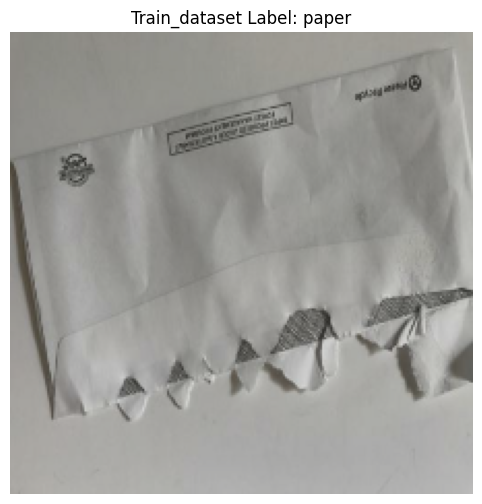




=========================== VALID_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 1.0
min-intensity: 0.0
label: 4 -> plastic
label-shape: ()
label-type: <dtype: 'int32'>



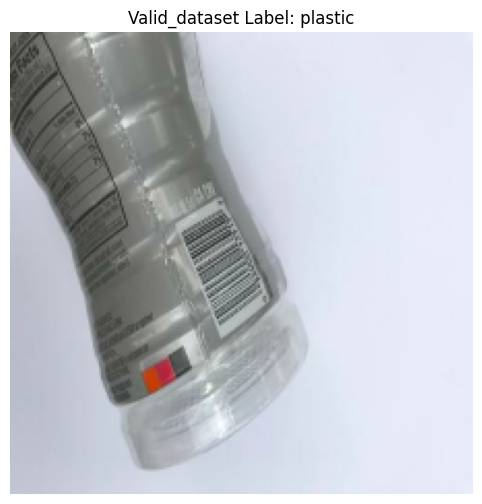

In [24]:
inspector.inspect(
    train_dataset=train_tf_dataset_loaded,
    valid_dataset=valid_tf_dataset_loaded,
    idx=10
)

Kita melakukan batch pada dataset training dan validasi, kemudian melakukan prefetching dan caching agar performa pelatihan lebih efisien. Dataset test hanya menggunakan prefetching dan caching, tanpa batching, karena umumnya tidak diperlukan batch untuk data test.

In [25]:
train_tf_images_batched = train_tf_dataset_loaded.batch(config.batch_size).prefetch(tf.data.AUTOTUNE).cache()
valid_tf_images_batched = valid_tf_dataset_loaded.batch(config.batch_size).prefetch(tf.data.AUTOTUNE).cache()

In [26]:
display_info_dataset_batched(config.batch_size, train_tf_dataset_loaded, train_tf_images_batched, kind='train dataset')
display_info_dataset_batched(config.batch_size, valid_tf_dataset_loaded, valid_tf_images_batched, kind='valid dataset')

===============================  TRAIN DATASET  ================================
Info data: <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Number of data: 2274
AFTER BATCH: 32
Number of data: 72
===============================  VALID DATASET  ================================
Info data: <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Number of data: 253
AFTER BATCH: 32
Number of data: 8


## Step 3. Training Model

### function

In [27]:
class TrainingLogger(tf.keras.callbacks.Callback):
    """
    Callback untuk mencatat hasil pelatihan pada setiap epoch ke dalam file CSV.

    Args:
        log_file (str): Path ke file log CSV.
        batch_size (int): Ukuran batch yang digunakan dalam pelatihan.
    """
    def __init__(self, log_file, batch_size):
        super(TrainingLogger, self).__init__()
        self.log_file = log_file
        self.batch_size = batch_size

        # Membuat file CSV dan menulis header-nya jika belum ada
        if not os.path.exists(log_file):
            os.makedirs(os.path.dirname(self.log_file), exist_ok=True)
            with open(log_file, mode='w', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(["Epoch", "Batch Size", "val_acc (%)", "val_loss (%)"])

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback yang dipanggil pada akhir setiap epoch untuk mencatat
        val_loss dan val_accuracy ke dalam file CSV.

        Args:
            epoch (int): Indeks epoch yang sedang berlangsung.
            logs (dict): Dictionary yang menyimpan metrik pelatihan seperti val_loss dan val_accuracy.
        """
        val_loss = logs.get('val_loss', 0) * 100  # Mengonversi ke persen
        val_acc = logs.get('val_accuracy', 0) * 100  # Mengonversi ke persen


        # Menulis hasil ke CSV
        with open(self.log_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, self.batch_size, round(val_acc, 4), round(val_loss, 4)])


# Callback untuk logging gambar prediksi
class WandbImageLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, label_list, sample_count=5):
        super().__init__()
        self.validation_data = validation_data
        self.label_list = label_list
        self.sample_count = sample_count

    def on_epoch_end(self, epoch, logs=None):
        # Ambil batch pertama dari data validasi
        images, labels = next(iter(self.validation_data))

        # Ambil sejumlah sampel prediksi untuk logging
        sample_images = images[:self.sample_count]
        sample_labels = labels[:self.sample_count]
        predictions = self.model.predict(sample_images)

        wandb_images = []
        for i in range(self.sample_count):
            true_label = self.label_list[sample_labels[i].numpy()]
            predicted_label = self.label_list[np.argmax(predictions[i])]

            plt.figure()
            plt.imshow(sample_images[i])
            plt.title(f"True: {true_label}, Pred: {predicted_label}")

            # Simpan gambar ke wandb
            wandb_images.append(wandb.Image(plt, caption=f"True: {true_label}, Pred: {predicted_label}"))
            plt.close()

        # Log gambar-gambar ke wandb
        wandb.log({"predictions": wandb_images}, step=epoch)

### main program

#### setup callbacks

Langkah ini mendefinisikan beberapa callback yang berguna selama proses pelatihan model, serta melakukan pelatihan model dengan callback yang ditentukan. Callback ini membantu memantau metrik dan menyimpan hasil model selama pelatihan.

- **TrainingLogger**: Callback ini bertugas mencatat hasil pelatihan seperti `val_accuracy` dan `val_loss` setelah setiap epoch ke dalam file CSV. Hal ini membantu dalam memantau performa model di setiap epoch tanpa harus melihat output terminal secara langsung.
- **ModelCheckpoint**: Callback ini menyimpan model setiap kali terjadi peningkatan performa berdasarkan nilai `val_loss`. Model terbaik akan disimpan di lokasi yang ditentukan dalam file `TARGET_KERAS_MODEL_PATH`.
- **ReduceLROnPlateau**: Callback ini akan mengurangi learning rate secara otomatis jika model tidak menunjukkan peningkatan setelah beberapa epoch tertentu, berdasarkan parameter `patience`. Ini membantu agar model tidak terjebak di local minima dan bisa mencapai performa lebih baik.
- **EarlyStopping**: Callback ini menghentikan pelatihan secara otomatis jika model tidak menunjukkan peningkatan setelah sejumlah epoch tertentu, dengan parameter `patience`. Hal ini bertujuan menghindari overfitting.

Setelah semua callback didefinisikan, model dilatih menggunakan dataset yang sudah dibatch, divalidasi, dan dipantau oleh callback ini.


In [28]:
# Inisialisasi callback untuk logging hasil pelatihan
training_logger = TrainingLogger(
    log_file=TABEL_TRAINING_PATH,  # Path untuk menyimpan log hasil pelatihan
    batch_size=config.batch_size  # Batch size yang digunakan
)

# Callback untuk menyimpan model terbaik berdasarkan val_loss terendah
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=TARGET_KERAS_MODEL_PATH,  # Path untuk menyimpan model terbaik
    monitor='val_loss',  # Metode evaluasi adalah val_loss
    save_best_only=True,  # Hanya simpan model terbaik
    save_weights_only=False,  # Simpan seluruh model, bukan hanya bobot
    mode='min',  # Simpan model ketika val_loss mencapai nilai terendah
    verbose=1  # Tampilkan progress saat menyimpan model
)

# Callback untuk mengurangi learning rate jika val_loss tidak membaik setelah beberapa epoch
plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',  # Pantau val_loss
  factor=0.5,  # Kurangi learning rate dengan faktor 0.5
  patience=10,  # Berapa banyak epoch yang harus ditunggu sebelum menurunkan learning rate
  verbose=1,  # Tampilkan informasi saat learning rate diturunkan
  mode='auto',  # Secara otomatis mendeteksi apakah harus meminimalkan atau memaksimalkan
  min_delta=0.001,  # Perubahan minimal pada val_loss yang diperlukan untuk dianggap sebagai peningkatan
  cooldown=0,  # Berapa lama untuk menunggu sebelum menurunkan lagi setelah perbaikan
  min_lr=0  # Learning rate minimal
)

# Callback untuk menghentikan pelatihan lebih awal jika val_loss tidak membaik
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',  # Pantau val_loss
  patience=25,  # Berhenti jika tidak ada perbaikan setelah 25 epoch
  restore_best_weights=True,  # Kembalikan bobot terbaik setelah selesai pelatihan
  verbose=1  # Tampilkan progress penghentian pelatihan
)

# Tambahkan callback ini ke dalam model.fit()
wandb_logger = WandbImageLogger(
    validation_data=valid_tf_images_batched,  # Data validasi
    label_list=LABEL_LIST,  # Daftar label (misalnya: ['cardboard', 'glass', ...])
    sample_count=10  # Jumlah gambar yang ingin dilog setiap epoch
)

#### training stage

In [ ]:
# Melatih model dengan dataset dan callback
history = model.fit(
    train_tf_images_batched,  # Dataset pelatihan yang sudah dibatch
    validation_data=valid_tf_images_batched,  # Dataset validasi yang sudah dibatch
    epochs=config.epochs,
    class_weight=CLASS_WEIGHTS,
    callbacks=[
        training_logger,  # Logger untuk mencatat hasil pelatihan
        checkpoint_callback,  # Simpan model terbaik
        plateau_callback,  # Sesuaikan learning rate jika diperlukan
        early_stopping, # Hentikan pelatihan jika tidak ada peningkatan
        wandb_logger,
        WandbMetricsLogger(),
  ]
)

wandb.finish()

Epoch 1/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.3527 - loss: 1.7035
Epoch 1: val_loss improved from inf to 0.89512, saving model to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet/artifacts/objects/DenseNet121_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 91s 848ms/step - accuracy: 0.3542 - loss: 1.6994 - val_accuracy: 0.6838 - val_loss: 0.8951 - learning_rate: 0.0010
Epoch 2/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6586 - loss: 0.9057
Epoch 2: val_loss improved from 0.89512 to 0.69753, saving model to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet/artifacts/objects/DenseNet121_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.6592 - loss: 0.9047 - val_accuracy: 0.7787 - val_loss: 0.6975 - learning_rate: 0.0010
Epoch 3/150
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7568 - loss: 0.7101
Epoch 3: val_loss i

epoch/accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch/learning_rate,███████████████████████▄▄▄▄▄▄▄▄▂▂▂▂▂▂▁▁▁
epoch/loss,█▇▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▂▁▂▃▄▄▅▅▆▆▆▅▆▆▆▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇████████
epoch/val_loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.9934
epoch/epoch,100
epoch/learning_rate,6e-05
epoch/loss,0.06065
epoch/val_accuracy,0.92095


# MODEL EVALUATION

## function

In [ ]:
def plot_training_history(history, save_path):
    """
    Plot training and validation accuracy and loss curves.

    Args:
    - history: History object yang dikembalikan oleh model.fit()
    - save_path (str): Path di mana gambar kurva akan disimpan.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # Plot akurasi
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Buat direktori jika belum ada, lalu simpan plot
    dir_path = os.path.dirname(save_path)
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(save_path)

    plt.show()

In [ ]:
def evaluate_model(
      model,
      tf_dataset,
      class_names,
      confusion_plot_path=None,
      classification_report_path=None,
      save_plot=True,
      save_report=True,
      normalize=False,  # Tambahin opsi untuk normalisasi confusion matrix
      figsize=(6,4)
    ):
    """
    Evaluasi model dan hasilkan confusion matrix serta classification report untuk klasifikasi biner atau multiclass.

    Args:
    - model: Model yang sudah dilatih.
    - tf_dataset: Dataset untuk evaluasi.
    - class_names: Daftar nama kelas yang ada.
    - confusion_plot_path: Path untuk menyimpan confusion matrix plot.
    - classification_report_path: Path untuk menyimpan classification report.
    - save_plot: Simpan confusion matrix plot jika True.
    - save_report: Simpan classification report jika True.
    - normalize: Jika True, confusion matrix akan di-normalisasi (skala 0.0 - 1.0).
    """
    # Ambil label asli dan prediksi model
    y_true = []
    y_pred = []

    # Lakukan evaluasi pada setiap batch
    for images, labels in tqdm(tf_dataset, desc='Evaluation'):
        # Buat prediksi probabilitas untuk setiap gambar
        predictions = model.predict(images, verbose=0)

        # Ambil label asli
        y_true.extend(tf.squeeze(labels).numpy())

        # Cek apakah klasifikasi biner atau multiclass
        if predictions.shape[1] == 1:
            # Binary classification: ubah prediksi berdasarkan threshold 0.5
            y_pred.extend((predictions > 0.5).astype(int))
        else:
            # Multiclass classification: ambil kelas dengan probabilitas tertinggi
            y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalisasi confusion matrix jika diperlukan
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"  # format untuk nilai desimal
    else:
        fmt = "d"  # format untuk nilai integer
    title = 'Confusion Matrix (Jumlah)'

    # Tampilkan dan simpan confusion matrix plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    if save_plot:
        plot_path = confusion_plot_path
        plot_dir_path = os.path.dirname(plot_path)
        os.makedirs(plot_dir_path, exist_ok=True)
        plt.savefig(plot_path)
        print(f"Confusion matrix plot saved to {plot_path}")

    plt.show()

    # Cetak dan simpan classification report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)

    if save_report:
        classification_report_dir_path = os.path.dirname(classification_report_path)
        os.makedirs(classification_report_dir_path, exist_ok=True)
        with open(classification_report_path, 'w') as f:
            f.write(report)
        print(f"Classification report saved to {classification_report_path}")


## main program

In [ ]:
evaluation = model.evaluate(valid_tf_images_batched)
print(f'Model evaluation on validation data: {evaluation}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9099 - loss: 0.2970
Model evaluation on validation data: [0.2792067527770996, 0.9051383137702942]


### save tabel epochs

In [ ]:
history_df = pd.DataFrame(history.history).reset_index()
history_df.rename(columns={'index': 'epoch'}, inplace=True)
history_df['epoch'] = history_df['epoch'] + 1
history_df = history_df.round({
    'accuracy': 4,
    'loss': 4,
    'val_accuracy': 4,
    'val_loss': 4,
    'learning_rate': 10
  }
)

history_df

,epoch,accuracy,loss,val_accuracy,val_loss,learning_rate
0,1,0.4617,1.4054,0.6838,0.8951,0.001000
1,2,0.6785,0.8705,0.7787,0.6975,0.001000
2,3,0.7555,0.7045,0.8142,0.6099,0.001000
3,4,0.7924,0.6106,0.8300,0.5544,0.001000
4,5,0.8153,0.5461,0.8182,0.5149,0.001000
...,...,...,...,...,...,...
96,97,0.9930,0.0618,0.9209,0.2848,0.000125
97,98,0.9930,0.0616,0.9209,0.2848,0.000125
98,99,0.9930,0.0614,0.9209,0.2847,0.000125
99,100,0.9934,0.0608,0.9209,0.2840,0.000063


In [ ]:
tabel_epoch_dir_path = os.path.dirname(TABEL_EPOCH_PATH)
os.makedirs(tabel_epoch_dir_path, exist_ok=True)
history_df.to_csv(TABEL_EPOCH_PATH, index=False)

### save plot training model

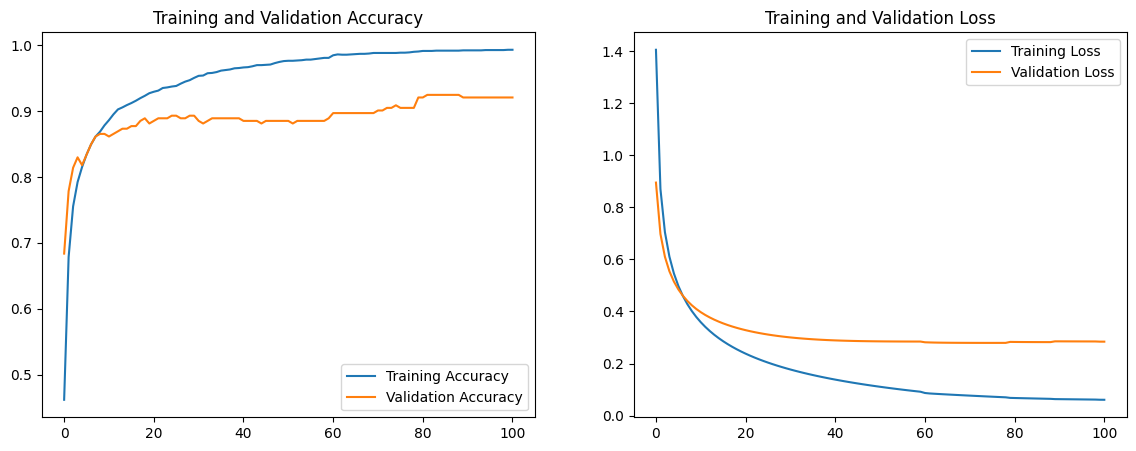

In [ ]:
plot_training_history(history, PLOT_TRAINING_PATH)

### save confusion matriks dan classification report

In [ ]:
best_model = tf.keras.models.load_model(TARGET_KERAS_MODEL_PATH)

Evaluation: 100%|██████████| 8/8 [00:01<00:00,  6.23it/s]


Confusion matrix plot saved to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet/artifacts/reports/DenseNet121/plot_confusion_matrix.png


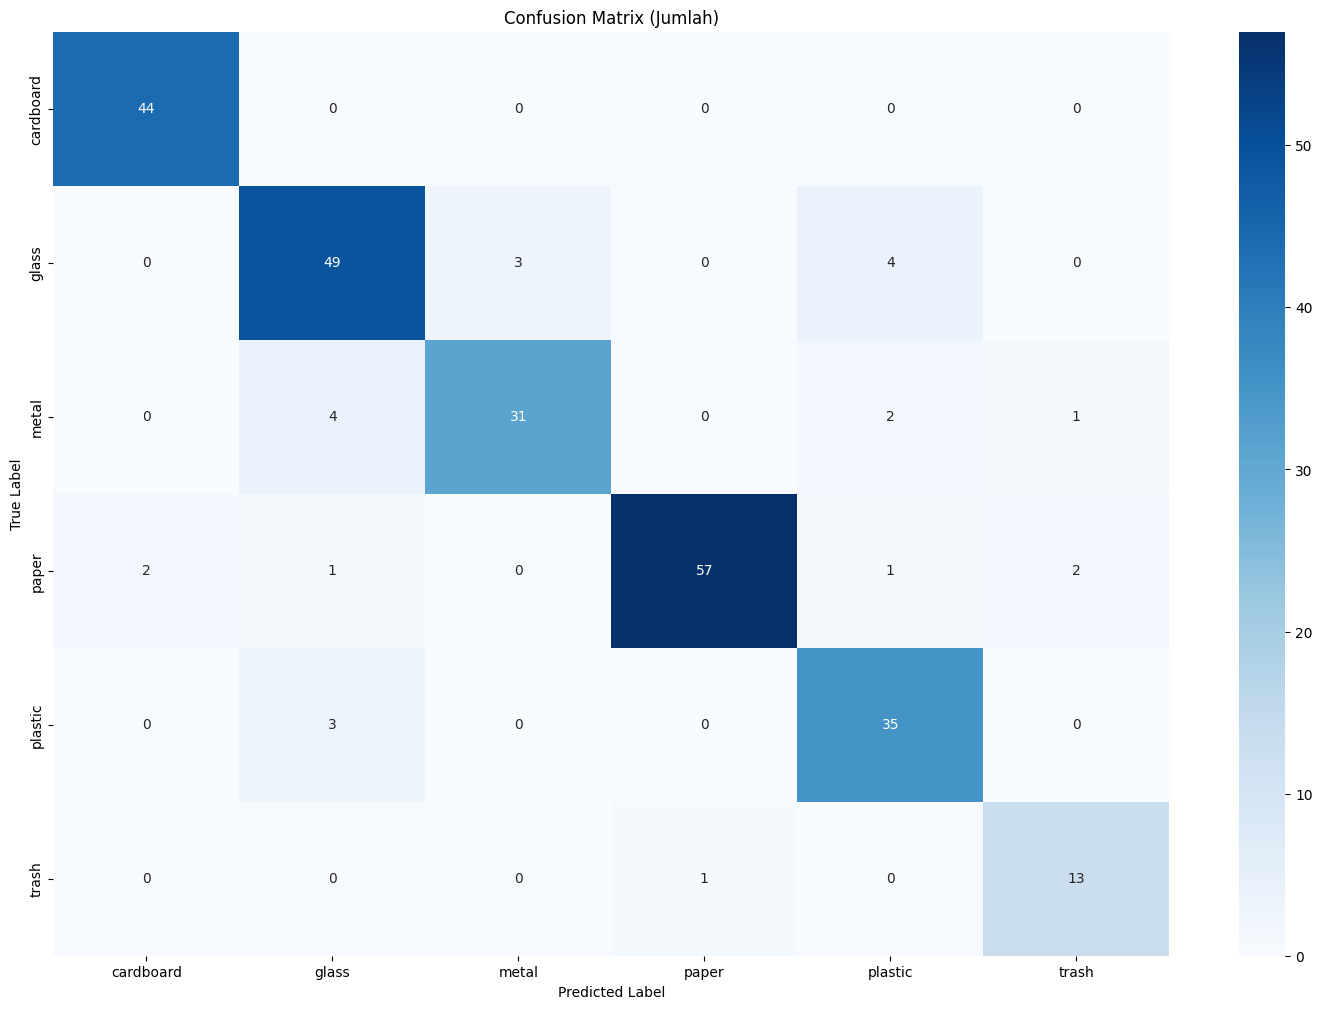

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      1.00      0.98        44
       glass       0.86      0.88      0.87        56
       metal       0.91      0.82      0.86        38
       paper       0.98      0.90      0.94        63
     plastic       0.83      0.92      0.88        38
       trash       0.81      0.93      0.87        14

    accuracy                           0.91       253
   macro avg       0.89      0.91      0.90       253
weighted avg       0.91      0.91      0.91       253

Classification report saved to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/TrashNet/artifacts/reports/DenseNet121/classification_report.txt


In [ ]:
evaluate_model(
    best_model,
    valid_tf_images_batched,
    LABEL_LIST,
    confusion_plot_path=PLOT_CONFUSION_MATRIX_PATH,
    classification_report_path=CLASSIFICATION_REPORT_PATH,
    save_plot=True,
    save_report=True,
    normalize=False,
    figsize=(18, 12)
)

### Hyperparameter Tuning

In [ ]:
def build_model(input_shape, num_classes, pretrained_model):
    # Input layer
    input_layer = tf.keras.Input(shape=input_shape)

    # Freeze pretrained model
    pretrained_model.trainable = False

    # Passing input through pretrained base model
    x = pretrained_model(input_layer, training=False)

    # Global average pooling layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Output layer with softmax activation for multiclass classification
    output_num = 1 if len(num_classes) == 2 else len(num_classes)
    activation = 'sigmoid' if output_num == 1 else 'softmax'
    output_layer = tf.keras.layers.Dense(output_num, activation=activation)(x)

    # Compile the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


# Sweep Configuration
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'values': [0.0001, 0.001]},
        'batch_size': {'values': [16, 32, 64]},
        'epochs': {'values': [30]},
    }
}

# Initialize the sweep and run it
sweep_id = wandb.sweep(sweep_config, project='trashnet-adatama-test')

def train(config=None):
    with wandb.init(config=config):
      config = wandb.config

      # Build and compile the model with sweep hyperparameters
      model = build_model(
          input_shape=(*IMAGE_SIZE, 3),
          num_classes=LABEL_LIST,
          pretrained_model=base_model,
      )

      optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
      model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

      # Training and validation data
      train_data = train_tf_images_batched
      val_data = valid_tf_images_batched

      # Train the model with the sweep configurations
      model.fit(
          train_tf_images_batched,
          validation_data=valid_tf_images_batched,
          epochs=config.epochs,
          class_weight=CLASS_WEIGHTS,
          callbacks=[
              tf.keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: wandb.log({"val_accuracy": logs["val_accuracy"], "train_accuracy": logs["accuracy"]})
            )
          ]
      )

wandb.agent(sweep_id, function=train, count=5)

Create sweep with ID: zob6eif3
Sweep URL: https://wandb.ai/kanshinbatosai-universitas-diponegoro/trashnet-adatama-test/sweeps/zob6eif3


wandb: Agent Starting Run: 9kun9onm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 357ms/step - accuracy: 0.4034 - loss: 1.5459 - val_accuracy: 0.6403 - val_loss: 0.9244
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7082 - loss: 0.8363 - val_accuracy: 0.7194 - val_loss: 0.7241
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.7705 - loss: 0.6742 - val_accuracy: 0.7470 - val_loss: 0.6275
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8014 - loss: 0.5819 - val_accuracy: 0.7787 - val_loss: 0.5679
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.8276 - loss: 0.5191 - val_accuracy: 0.7984 - val_loss: 0.5269
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.8459 - loss: 0.4725 - val_accuracy: 0.8182 - val_loss: 0.4964
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8561 - loss: 0.4358 - val_accuracy: 0.8300 - val_loss: 0.4725
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8700 - loss: 0.4057 - val_accuracy: 0.84

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
train_accuracy,0.95251
val_accuracy,0.88142


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jn2f1btw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - accuracy: 0.3561 - loss: 1.5840 - val_accuracy: 0.6996 - val_loss: 0.8958
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.7083 - loss: 0.8147 - val_accuracy: 0.7549 - val_loss: 0.7044
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.7595 - loss: 0.6547 - val_accuracy: 0.7787 - val_loss: 0.6123
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.7997 - loss: 0.5659 - val_accuracy: 0.8024 - val_loss: 0.5538
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8245 - loss: 0.5051 - val_accuracy: 0.8182 - val_loss: 0.5129
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.8513 - loss: 0.4596 - val_accuracy: 0.8340 - val_loss: 0.4822
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.8614 - loss: 0.4236 - val_accuracy: 0.8419 - val_loss: 0.4580
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.8774 - loss: 0.3939 - val_accuracy: 0.85

train_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████████
val_accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇████████████████
train_accuracy,0.95119
val_accuracy,0.89723


wandb: Agent Starting Run: hqgfbxbl with config:
wandb: 	batch_size: 16
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 346ms/step - accuracy: 0.3848 - loss: 1.5851 - val_accuracy: 0.7075 - val_loss: 0.8713
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.6986 - loss: 0.8410 - val_accuracy: 0.7549 - val_loss: 0.6901
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.7626 - loss: 0.6719 - val_accuracy: 0.7826 - val_loss: 0.6065
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.8102 - loss: 0.5796 - val_accuracy: 0.7866 - val_loss: 0.5533
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8330 - loss: 0.5165 - val_accuracy: 0.8142 - val_loss: 0.5157
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8500 - loss: 0.4694 - val_accuracy: 0.8261 - val_loss: 0.4871
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.8589 - loss: 0.4321 - val_accuracy: 0.8340 - val_loss: 0.4644
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.8704 - loss: 0.4016 - val_accuracy: 0.8

train_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████
val_accuracy,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇███████████████
train_accuracy,0.95119
val_accuracy,0.89328


wandb: Agent Starting Run: 14wzwlqn with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 328ms/step - accuracy: 0.4094 - loss: 1.5334 - val_accuracy: 0.6640 - val_loss: 0.8895
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.6885 - loss: 0.8287 - val_accuracy: 0.7589 - val_loss: 0.7063
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.7600 - loss: 0.6623 - val_accuracy: 0.7866 - val_loss: 0.6225
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7922 - loss: 0.5731 - val_accuracy: 0.7866 - val_loss: 0.5685
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.8196 - loss: 0.5127 - val_accuracy: 0.8063 - val_loss: 0.5295
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.8475 - loss: 0.4676 - val_accuracy: 0.8182 - val_loss: 0.4994
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8599 - loss: 0.4318 - val_accuracy: 0.8261 - val_loss: 0.4752
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.8749 - loss: 0.4023 - val_accuracy: 0.

train_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████
val_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
train_accuracy,0.95031
val_accuracy,0.88538


wandb: Agent Starting Run: dc1567iv with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 325ms/step - accuracy: 0.1649 - loss: 2.0790 - val_accuracy: 0.2372 - val_loss: 1.7461
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.2786 - loss: 1.7445 - val_accuracy: 0.3399 - val_loss: 1.5374
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.3720 - loss: 1.5549 - val_accuracy: 0.4466 - val_loss: 1.3798
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.4553 - loss: 1.4067 - val_accuracy: 0.5296 - val_loss: 1.2578
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.5174 - loss: 1.2898 - val_accuracy: 0.5692 - val_loss: 1.1622
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.5637 - loss: 1.1966 - val_accuracy: 0.6285 - val_loss: 1.0861
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6012 - loss: 1.1211 - val_accuracy: 0.6561 - val_loss: 1.0248
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6163 - loss: 1.0590 - val_accuracy: 0.6

train_accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
val_accuracy,▁▂▄▅▅▆▆▇▇▇████████████████████
train_accuracy,0.80387
val_accuracy,0.79051
